# What price should I sell my used cell phone for?

Let's say I have an unscratched used phone that was made in 2014 and want to sell it now. I go to eBay.com and check out similar closed autions to see how much the phones sold for. I believe that 3 factors determine whether the phone sells:
- scratched
- year
- price


I want to determine the listing price for my phone in the eBay auction so that it sells for as much as possible without diminshing the likeihood of selling on the first auction listing.    

Inspiration: 
http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/#fully-worked-example-what-price-should-i-sell-my-used-phone-for
https://www.srose.biz/wp-content/uploads/2020/08/Bayesian-logistic-regression-with-pymc3.html

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Here are 6 fake closed eBay listings that we will use to build our model of whether the phone was sold. 

In [2]:
df = pd.DataFrame({'sold': [1, 1, 0, 0, 1, 1], 
                   'scratched': [0, 0, 1, 0, 0, 0], 
                   'year':[2014, 2015, 2010, 2014, 2015, 2016],
                   'price':[50, 70, 40, 100, 90, 100]})
df

,sold,scratched,year,price
0,1,0,2014,50
1,1,0,2015,70
2,0,1,2010,40
3,0,0,2014,100
4,1,0,2015,90
5,1,0,2016,100


## Explore the Data

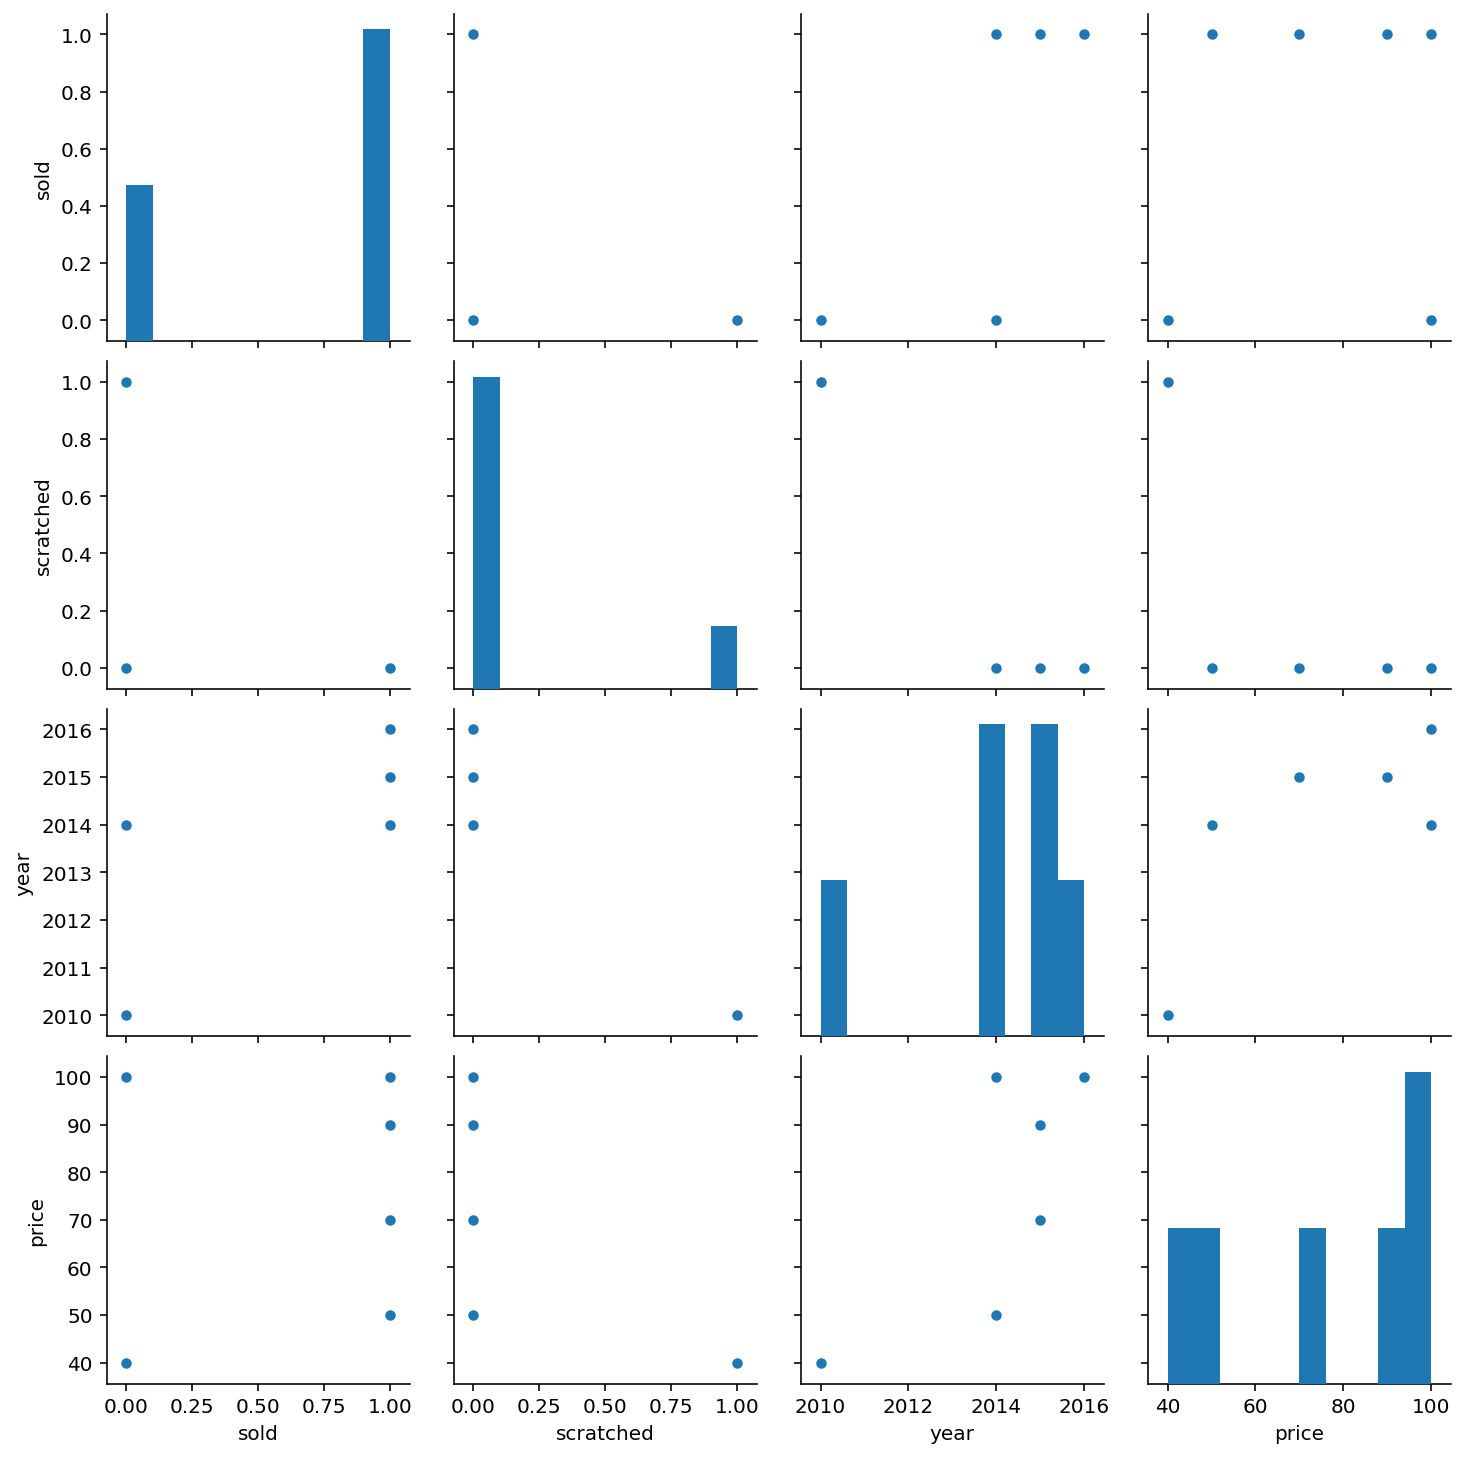

In [3]:
g = sns.pairplot(df)

## Fit Bayesian Logistic Model
Let's fit a simple Bayesian Logistic Regression model to this data.

Let’s use the default prior specification for GLM coefficients that PyMC3 gives us, which is p(θ)=N(0,10^12*I). This is a very vague or weakly informative prior that will let the data speak for itsef.

In [4]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "sold ~ scratched + year + price", df, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag",random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [price, year, scratched, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1907 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9171240528108986, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


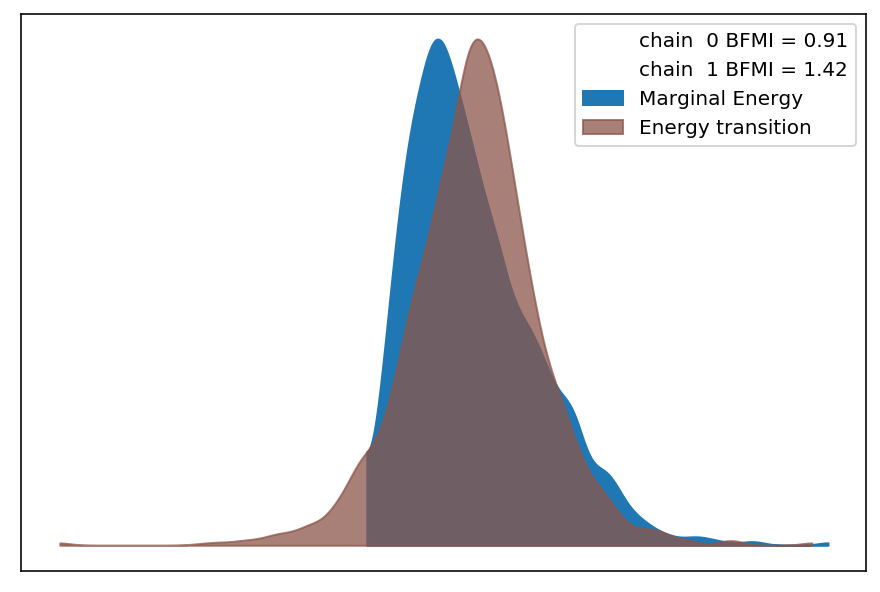

In [5]:
# make sure convergence looks good
az.plot_energy(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A351318A08>,
      dtype=object)

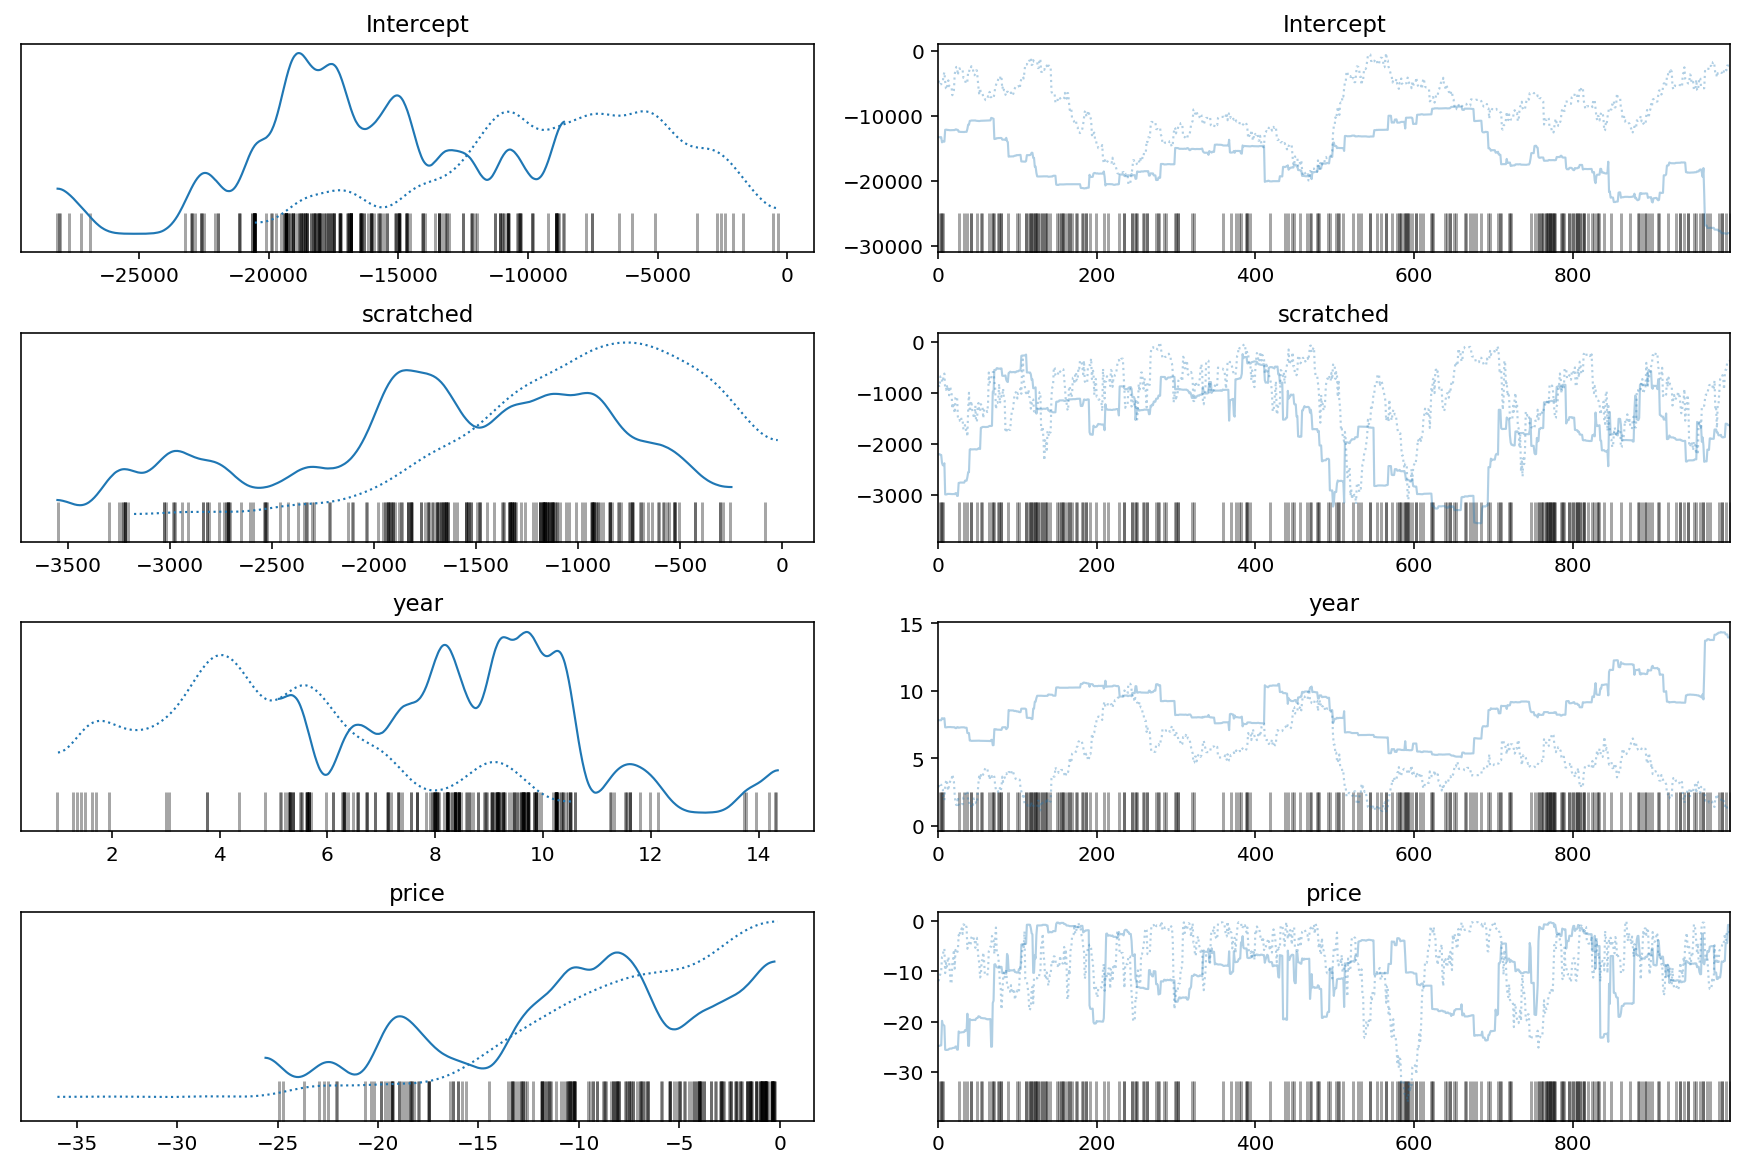

In [6]:
az.plot_trace(trace, compact=True)

In [7]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [74]:
logistic_model.model

In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-12709.470,5844.016,-20738.867,-1070.591,3042.251,2348.673,4.0,13.0,1.47
scratched,-1345.460,787.958,-3029.764,-207.647,348.825,262.314,5.0,33.0,1.30
year,6.762,2.867,1.283,10.618,1.528,1.186,4.0,13.0,1.50
price,-9.158,6.730,-22.044,-0.197,1.010,0.719,46.0,96.0,1.04


<Figure size 648x504 with 0 Axes>

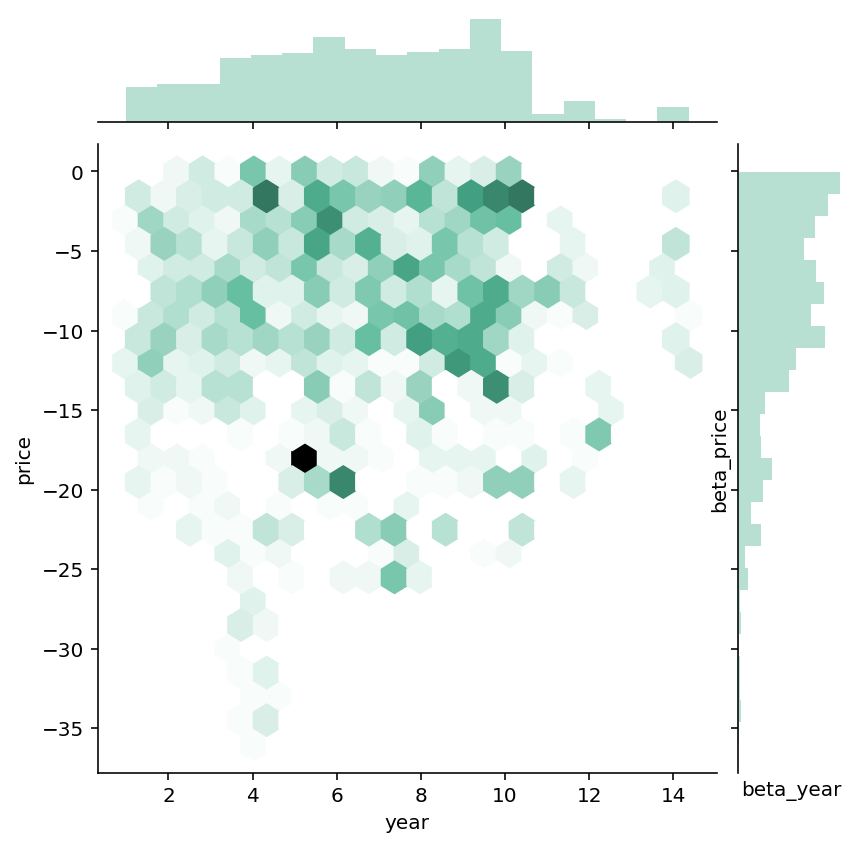

In [9]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace.posterior["year"], trace.posterior["price"], kind="hex", color="#4CB391")
plt.xlabel("beta_year")
plt.ylabel("beta_price");

## Lasso Logistic Model

In [20]:
with pm.Model() as logistic_model_p:    
    priors = {"Intercept": pm.Normal.dist(mu=0, sigma=50), "Regressor": pm.Laplace.dist(mu=0, b=0.05)}
    pm.glm.GLM.from_formula(
        "sold ~ scratched + year + price", df, family=pm.glm.families.Binomial(),priors=priors)
    
    trace_p = pm.sample(500, init="adapt_diag",random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [price, year, scratched, Intercept]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 300 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6864883554892888, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
az.summary(trace_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.663,43.376,-74.482,103.790,5.918,4.777,57.0,39.0,1.04
scratched,0.000,0.062,-0.139,0.094,0.005,0.004,117.0,121.0,1.02
year,-0.003,0.021,-0.052,0.036,0.003,0.002,58.0,37.0,1.04
price,0.012,0.031,-0.036,0.080,0.003,0.002,95.0,141.0,1.03


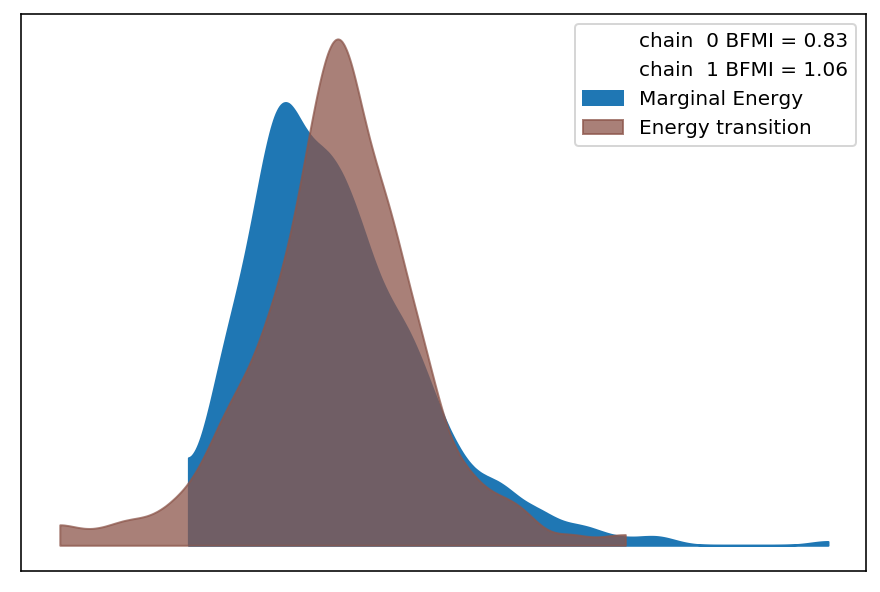

In [30]:
# make sure convergence looks good
az.plot_energy(trace_p)

In [73]:
logistic_model_p.model

## Logistic Regression with Normal priors (Manual Model Specification required)

We will use a Flat prior on β0 and we will place informative priors on the other coefficients. For example, since I believe that having a scratch would likely decrease the probability that a phone sold I will use the following prior β1∼Normal(−1,1).

We will use the context manager with to define a manual_logistic_model that we can refer to later as a probabilistic model:

- The random variables for the unobserved parameters for intercept and  3 features are expressed using priors that assume:
    - beta_scratched: normal distributions with mean -1  and standard deviation of 1
    - beta_year: normal distributions with mean  1  and standard deviation of 1
    - beta_price: normal distributions with mean  -2  and standard deviation of 1
- The likelihood combines the parameters with the data according to the specification of the logistic regression.
- The outcome is modeled as a Bernoulli RV with success probability given by the likelihood.

In [72]:
with pm.Model() as manual_logistic_model:    
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Flat('intercept')
    beta_1 = pm.Normal('beta_scratched', -1, sd=1)
    beta_2 = pm.Normal('beta_year', 1, sd=1)
    beta_3 = pm.Normal('beta_price', -2, sd=1)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 * df.scratched + beta_2 * df.year + beta_3 * df.price)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=df.sold)
   
    manual_trace = pm.sample(500, init="adapt_diag",random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_price, beta_year, beta_scratched, intercept]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2240 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


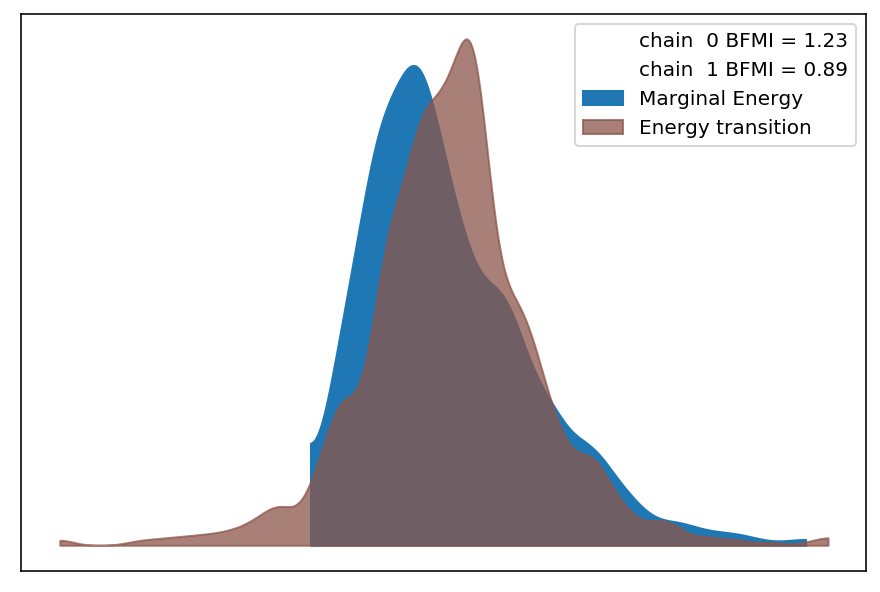

In [75]:
# make sure convergence looks good
az.plot_energy(manual_trace)

In [76]:
az.summary(manual_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-4316.917,1672.280,-7641.106,-1761.646,420.090,302.991,16.0,46.0,1.13
beta_scratched,-1.277,1.004,-3.193,0.461,0.097,0.069,107.0,212.0,1.01
beta_year,2.149,0.832,0.877,3.803,0.209,0.151,16.0,46.0,1.13
beta_price,-0.118,0.080,-0.271,0.018,0.014,0.010,39.0,168.0,1.03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3552DEA08>,
      dtype=object)

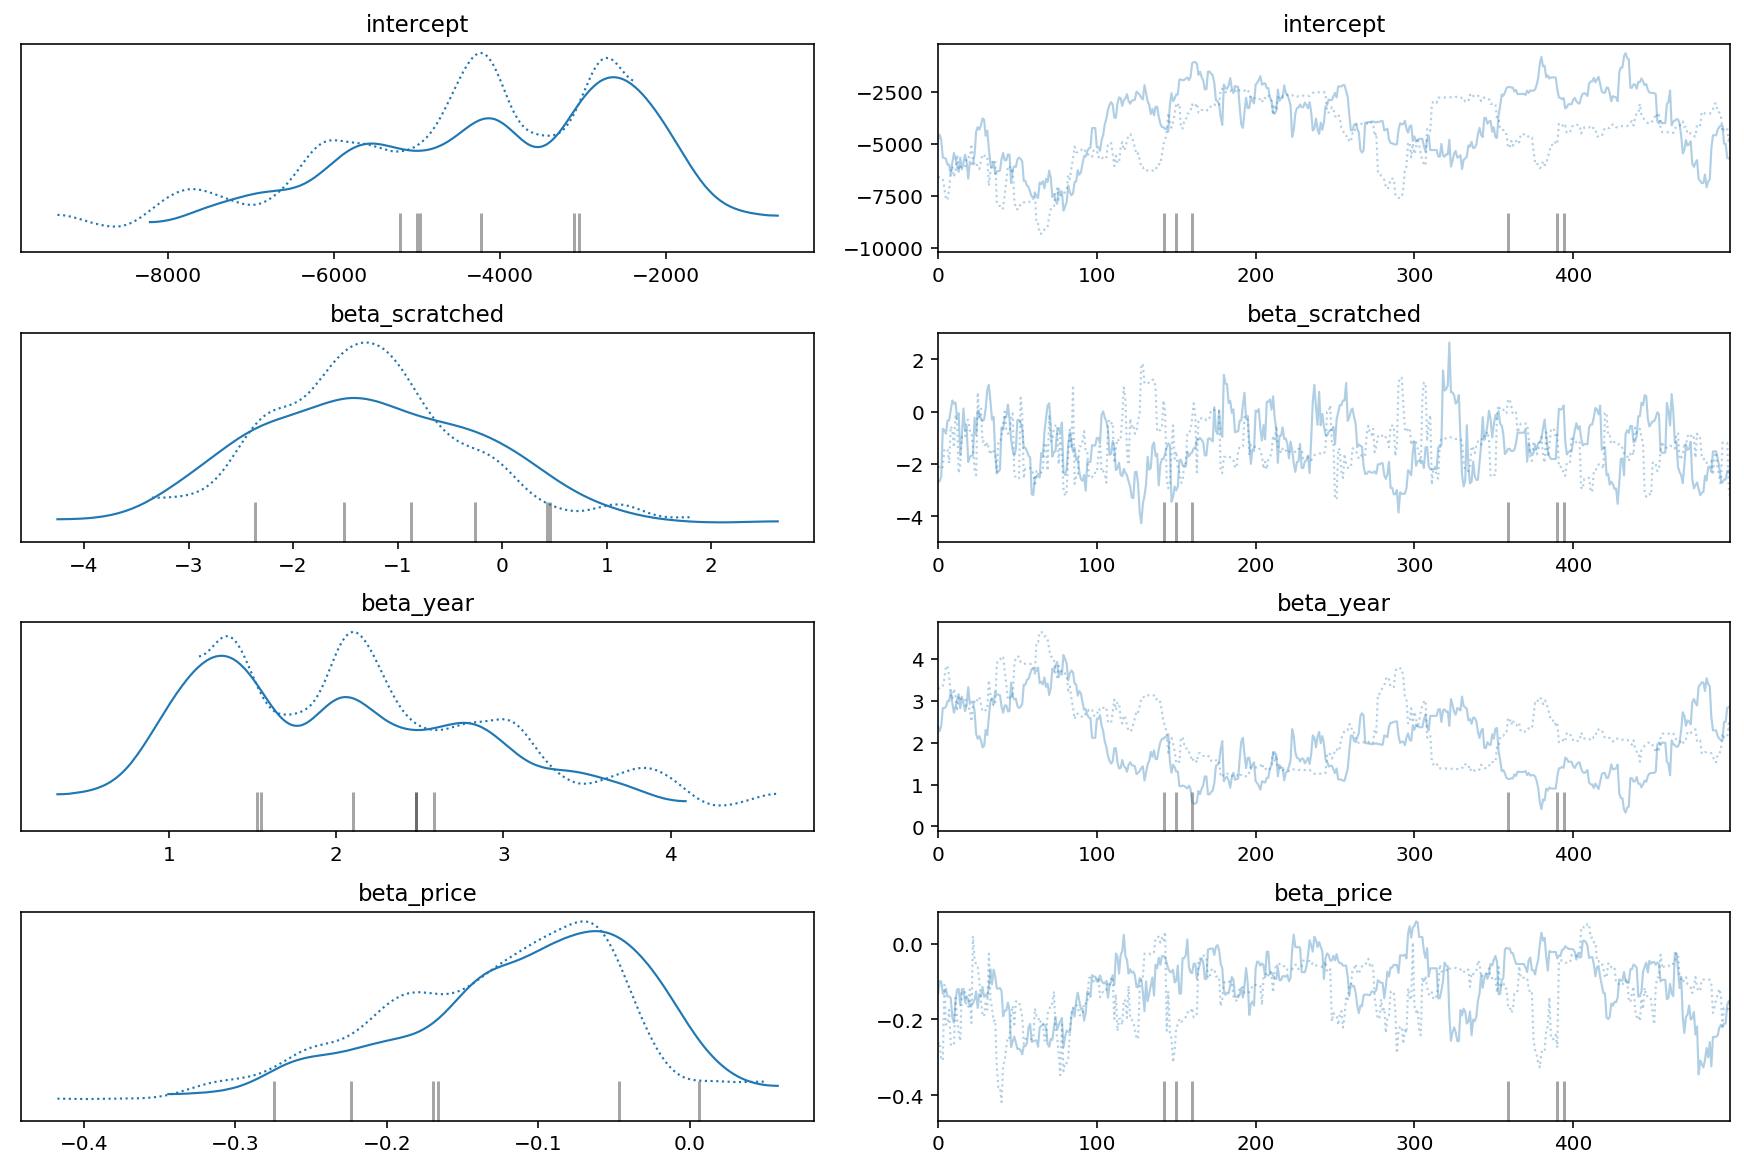

In [77]:
az.plot_trace(manual_trace, compact=True)

In [78]:
from IPython.display import HTML
manual_logistic_model.model

In [40]:
pm.model_to_graphviz(manual_logistic_model)

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Explore the models!

In [79]:
def lm_full(trace, price, scratched, year):
    shape = np.broadcast(scratched, year, price).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [scratched, year, price]])
    return 1 / (
        1
        + np.exp(
            -(
                trace["intercept"]
                + trace["beta_scratched"] * x_norm[0]
                + trace["beta_year"] * x_norm[1]
                + trace["beta_price"] * x_norm[2]
            )
        )
    )

# Linear model with price=x, scratched == 0 and year=2010
lm1 = lambda x, samples: lm_full(samples, x, 0.0, 2010)

# Linear model with price=x, scratched == 0 and year=2012
lm2 = lambda x, samples: lm_full(samples, x,  0.0, 2012)

# Linear model with price=x, scratched == 0 and year=2014
lm3 = lambda x, samples: lm_full(samples, x,  0.0, 2014)

# Linear model with price=x, scratched == 0 and year=2018
lm4 = lambda x, samples: lm_full(samples, x,  0.0, 2018)

# Linear model with price=x, scratched == 1 and year=2018
lm_scr = lambda x, samples: lm_full(samples, x,  1.0, 2014)

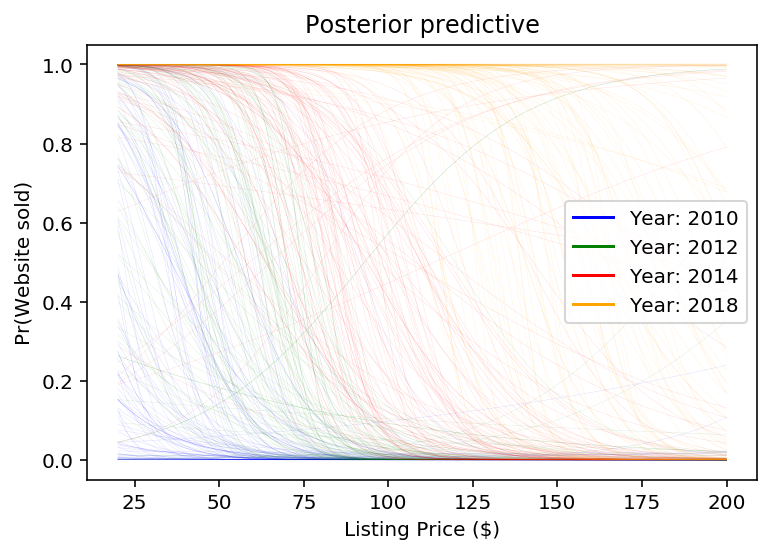

In [80]:
# Plot the posterior predictive distributions of Pr(sold) as function of listing_price (x) 
price_range = np.linspace(20, 200, 500)
pm.plot_posterior_predictive_glm(
    manual_trace, eval=price_range, lm=lm1, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    manual_trace,
    eval=price_range,
    lm=lm2,
    samples=100,
    color="green",
    alpha=0.15,
)
pm.plot_posterior_predictive_glm(
    manual_trace, eval=price_range, lm=lm3, samples=100, color="red", alpha=0.15
)

pm.plot_posterior_predictive_glm(
    manual_trace, eval=price_range, lm=lm4, samples=100, color="orange", alpha=0.15
)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm1"], [], color="b", label="Year: 2010")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Year: 2012")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Year: 2014")
orange_line = mlines.Line2D(["lm4"], [], color="orange", label="Year: 2018")
plt.legend(handles=[blue_line, green_line, red_line,orange_line], loc="best")
plt.ylabel("Pr(Website sold)")
plt.xlabel("Listing Price ($)")
plt.show()

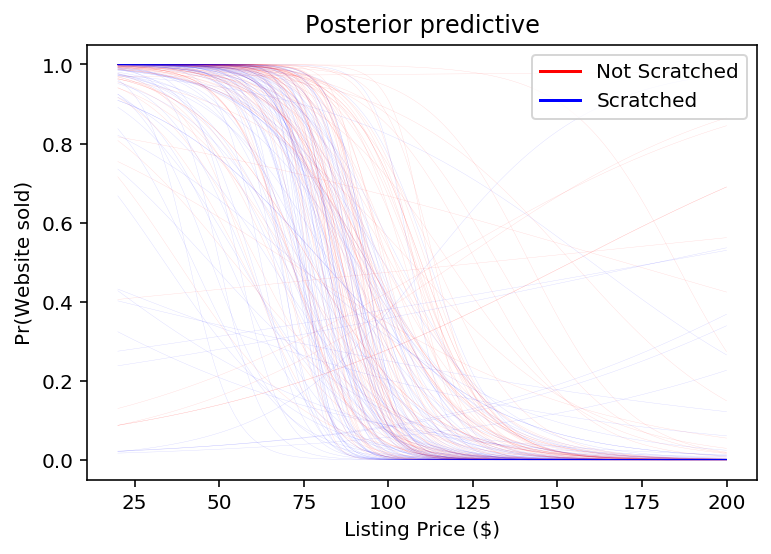

In [81]:
# Plot the posterior predictive distributions of Pr(sold) as function of listing_price (x) 
price_range = np.linspace(20, 200, 500)
pm.plot_posterior_predictive_glm(
    manual_trace, eval=price_range, lm=lm3, samples=100, color="red", alpha=0.15
)

pm.plot_posterior_predictive_glm(
    manual_trace, eval=price_range, lm=lm_scr, samples=100, color="blue", alpha=0.15
)

import matplotlib.lines as mlines

red_line = mlines.Line2D(["lm3"], [], color="r", label="Not Scratched")
blue_line = mlines.Line2D(["lm_scr"], [], color="b", label="Scratched")
plt.legend(handles=[red_line,blue_line], loc="best")
plt.ylabel("Pr(Website sold)")
plt.xlabel("Listing Price ($)")
plt.show()

## Optimization
Now we have our posterior or the fitted model based on the website listing data provided so we can create a loss function over which to optimize the listing price. In this loss function, we want to maximize the expected return from selling a website. 

Loss function =  Pr(selling website if listed at particular price) * listing_price

Alternatively, we could choose to maximize a more complex function if we were interested in buying websites that don't require too much upkeep relative to its net profit. In this use case, the loss function would need to strike a balance between the cost of running/maintaining these websites and the monthly net profit. 

In [117]:
# get predictive posterior samples
def posterior_predict(price,trace=manual_trace,nsamples = 100):
    # Linear model with listing_price=x, net_profit == 500 and site_age=3, authority_score = 45, monthly_traffic=1000
    lmX = lambda x: lm_full(x, price, 0.0, 2014)
    post_pred = []
    for rand_loc in np.random.randint(0, len(trace), nsamples):
        trace1 = trace.posterior.to_dataframe().to_dict(orient="records")
        rand_sample = trace1[rand_loc]
        post_pred.append(lmX(rand_sample))
    return np.array(post_pred)

In [118]:
posterior_predict(200)

array([1.36050909e-04, 6.71900685e-05, 1.36050909e-04, 3.47640261e-08,
       1.27310095e-05, 1.36050909e-04, 1.27310095e-05, 1.27310095e-05,
       6.71900685e-05, 6.71900685e-05, 1.36050909e-04, 3.47640261e-08,
       1.36050909e-04, 1.36050909e-04, 1.27310095e-05, 1.36050909e-04,
       1.27310095e-05, 1.36050909e-04, 1.36050909e-04, 3.47640261e-08,
       1.27310095e-05, 1.27310095e-05, 6.71900685e-05, 3.47640261e-08,
       6.71900685e-05, 3.47640261e-08, 3.47640261e-08, 1.36050909e-04,
       1.36050909e-04, 1.27310095e-05, 6.71900685e-05, 6.71900685e-05,
       3.47640261e-08, 6.71900685e-05, 1.27310095e-05, 1.36050909e-04,
       1.36050909e-04, 6.71900685e-05, 1.36050909e-04, 6.71900685e-05,
       6.71900685e-05, 1.27310095e-05, 1.27310095e-05, 6.71900685e-05,
       3.47640261e-08, 1.36050909e-04, 6.71900685e-05, 3.47640261e-08,
       1.36050909e-04, 1.27310095e-05, 1.36050909e-04, 6.71900685e-05,
       6.71900685e-05, 1.36050909e-04, 6.71900685e-05, 1.27310095e-05,
      

In [119]:
def loss(price):
    post_pred = posterior_predict(price)
    return -np.mean(post_pred*price)

In [120]:
# parameters for the optimization, we're just setting the bounds for listing price as 10, 200
bounds = [(10, 200)]
starting_value = [50.0]

In [121]:
from scipy import optimize

#minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: loss(*args), 
                              starting_value, 
                              bounds=bounds)

In [122]:
print('Optimal listing price = {}'.format(opt_stoch.x))
print('Optimal expected return = {}'.format(opt_stoch.fun))

Optimal listing price = [49.99999725]
Optimal expected return = -49.084999535092614


In [123]:
opt_stoch.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [124]:
opt_stoch.status

0

In [125]:
%%time
post_pred_test = []
for x in price_range:
    post_pred_test.append(loss(x))
post_pred_test = np.array(post_pred_test)    
post_pred_test

Wall time: 5min


array([-1.99910398e+01, -2.03524281e+01, -2.07133196e+01, -2.10723191e+01,
       -2.14350501e+01, -2.17934333e+01, -2.21524158e+01, -2.25169859e+01,
       -2.28738193e+01, -2.32314035e+01, -2.35947644e+01, -2.39517343e+01,
       -2.43168832e+01, -2.46742218e+01, -2.50303390e+01, -2.53920619e+01,
       -2.57528568e+01, -2.61124319e+01, -2.64686229e+01, -2.68278632e+01,
       -2.71935187e+01, -2.75479200e+01, -2.79067884e+01, -2.82639257e+01,
       -2.86281865e+01, -2.89790526e+01, -2.93428116e+01, -2.97080913e+01,
       -3.00513528e+01, -3.04177644e+01, -3.07731755e+01, -3.11239165e+01,
       -3.14803565e+01, -3.18650060e+01, -3.22159151e+01, -3.25629627e+01,
       -3.29272717e+01, -3.32895062e+01, -3.36281097e+01, -3.39850784e+01,
       -3.43578563e+01, -3.47038781e+01, -3.50736229e+01, -3.54219023e+01,
       -3.57853237e+01, -3.61202250e+01, -3.64958466e+01, -3.68566116e+01,
       -3.72106211e+01, -3.75631157e+01, -3.78600750e+01, -3.82916592e+01,
       -3.85777095e+01, -

Text(0.5, 1.0, 'Plot of Expected Return as function of Listing Price')

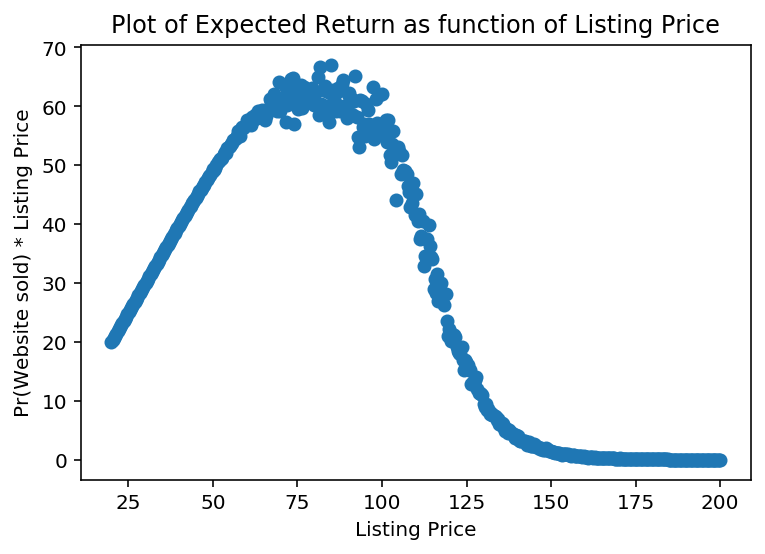

In [126]:
plt.scatter(price_range,-post_pred_test)
plt.xlabel('Listing Price')
plt.ylabel('Pr(Website sold) * Listing Price')
plt.title('Plot of Expected Return as function of Listing Price')

## Learnings
- Scaling features to be on the same order of magnitude significantly helps with convergence.